"""
An example to demonstrate online linear system identification

We demonstrate the use of OnlineLinearModel class with a simple linear system.
Take a 2D time-varying system dz/dt=A(t)z(t)+B(t)u(t), where A(t) and B(t)
are slowly varying with time. In particular, we take A(t)=(1+eps*t)*A0,
B(t)=(1+eps*t)*B0, and eps = 0.1 is small. It is discretize with
time step dt = 0.1. Denote the discrete system as z(k)=A(k)z(k-1)+
B(k)u(k-1). We define x(k) = [z(k-1);u(k-1)], y(k) = z(k),
F(k)=[A(k),B(k)], then the original system can be written as y(k)=F(k)x(k).

At time step k, define two matrix X(k) = [x(1),x(2),...,x(k)], 
Y(k) = [y(1),y(2),...,y(k)], that contain all the past snapshot pairs.
The best fit to the data is Fk = Yk*pinv(Xk).

An exponential weighting factor rho=sigma^2 (0<rho<=1) that places more 
weight on recent data can be incorporated into the definition of X(k) and
Y(k) such that X(k) = [sigma^(k-1)*x(1),sigma^(k-2)*x(2),...,
sigma^(1)*x(k-1),x(k)], Y(k) = [sigma^(k-1)*y(1),sigma^(k-2)*y(2),...,
sigma^(1)*y(k-1),y(k)].

At time step k+1, we need to include new snapshot pair x(k+1), y(k+1).
We would like to update the DMD matrix Fk = Yk*pinv(Xk) recursively 
by efficient rank-1 updating online DMD algorithm.

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [3]:
!pip install -r requirements.txt

In [4]:
!pip list

Package           Version    Location
----------------- ---------- ---------------------------------------
appdirs           1.4.4
attrs             20.3.0
black             20.8b1
click             7.1.2
control           0.8.4
cycler            0.10.0
iniconfig         1.1.1
kiwisolver        1.3.1
matplotlib        3.3.4
mypy-extensions   0.4.3
numpy             1.20.1
osysid            0.1.0      /Users/haozhang/Desktop/Research/osysid
packaging         20.9
pathspec          0.8.1
Pillow            8.1.0
pip               21.0.1
pluggy            0.13.1
py                1.10.0
pyparsing         2.4.7
pytest            6.2.2
python-dateutil   2.8.1
regex             2020.11.13
scipy             1.6.1
setuptools        47.1.0
six               1.15.0
toml              0.10.2
typed-ast         1.4.2
typing-extensions 3.7.4.3


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from osysid import OnlineLinearModel

ModuleNotFoundError: No module named 'osysid'

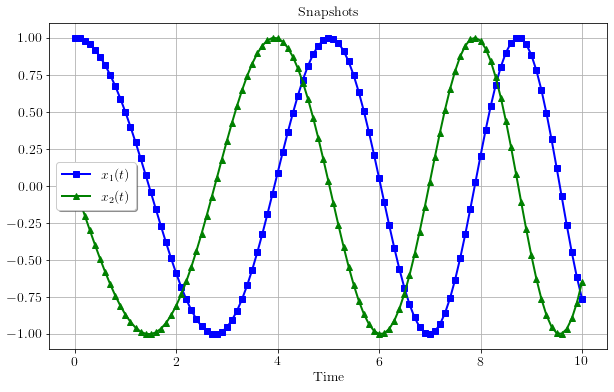

In [3]:
# define dynamics
epsilon = 1e-1


def dyn(x, t):
    x1, x2 = x
    dxdt = [(1+epsilon*t)*x2, -(1+epsilon*t)*x1]
    return dxdt


# integrate from initial condition [1,0]
tspan = np.linspace(0, 10, 101)
dt = 0.1
x0 = [1, 0]
xsol = odeint(dyn, x0, tspan).T
# extract snapshots
x, y = xsol[:, :-1], xsol[:, 1:]
t = tspan[1:]
# true dynamics, true eigenvalues
n, m = len(x[:, 0]), len(x[0, :])
A = np.empty((n, n, m))
evals = np.empty((n, m), dtype=complex)
for k in range(m):
    A[:, :, k] = np.array([[0, (1+epsilon*t[k])], [-(1+epsilon*t[k]), 0]])
    evals[:, k] = np.linalg.eigvals(A[:, :, k])

    
# visualize snapshots
plt.figure(figsize=(10,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(tspan, xsol[0, :], 'bs-', linewidth=2.0,  label='$x_1(t)$')
plt.plot(tspan, xsol[1, :], 'g^-', linewidth=2.0,  label='$x_2(t)$')
plt.legend(loc='best', fontsize=14, shadow=True)
plt.xlabel('Time', fontsize=14)
plt.title('Snapshots', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid()
plt.show()

In [4]:
# batch DMD
q = 10
AbatchDMD = np.empty((n, n, m))
evalsbatchDMD = np.empty((n, m), dtype=complex)
start = time.time()
for k in range(q, m):
    AbatchDMD[:, :, k] = y[:, :k+1].dot(np.linalg.pinv(x[:, :k+1]))
    evalsbatchDMD[:, k] = np.log(np.linalg.eigvals(AbatchDMD[:, :, k]))/dt
end = time.time()
print("Batch DMD, time = " + str(end-start) + " secs")


# Online DMD, weighting = 1
evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1.0)
odmd.initialize(x[:, :q], y[:, :q])
start = time.time()
for k in range(q, m):
    odmd.update(x[:, k], y[:, k])
    evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")


# Online DMD, weighting = 0.9
evalsonlineDMD2 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 0.9)
odmd.initialize(x[:, :q], y[:, :q])
start = time.time()
for k in range(q, m):
    odmd.update(x[:, k], y[:, k])
    evalsonlineDMD2[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 0.9, time = " + str(end-start) + " secs")

Batch DMD, time = 0.020748138427734375 secs
Online DMD, weighting = 1, time = 0.01684403419494629 secs
Online DMD, weighting = 0.9, time = 0.022623062133789062 secs


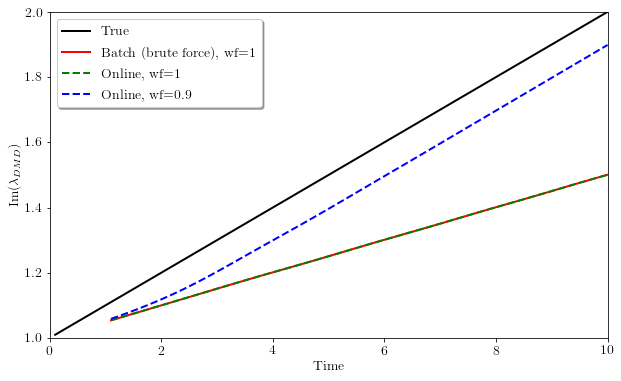

In [5]:
# visualize true, batch, online (weighting=1,0.9)
plt.figure(figsize=(10,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, np.imag(evals[0, :]), 'k-', label='True', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsbatchDMD[0, q:]),
         'r-', label='Batch (brute force), wf=1', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsonlineDMD1[0, q:]),
         'g--', label='Online, wf=1', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsonlineDMD2[0, q:]), 'b--',
         label='Online, wf=0.9', linewidth=2.0)
plt.tick_params(labelsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Im($\lambda_{DMD}$)', fontsize=14)
plt.legend(loc='best', fontsize=14, shadow=True)
plt.xlim([0, 10])
plt.ylim([1, 2])
plt.show()